## 05_model_summary & explainability

### **Model Comparison Summary**
#### The below table compares the performance of four models on the test set. Priorities are on **recall** (catching frauds) and **precision** (reducing false alarms)

| Model                   | Precision | Recall    | F1 Score  | ROC-AUC   |
| ----------------------- | --------- | --------- | --------- | --------- |
| Logistic Regression     | **0.780** | **0.952** | 0.858     | **0.982** |
| Random Forest           | **0.995** | 0.938     | **0.966** | 0.979     |
| XGBoost (RUS)           | 0.705     | 0.947     | 0.808     | 0.979     |
| LightGBM (RUS)          | 0.697     | 0.947     | 0.803     | 0.974     |

- **Best Recall (95.2%):** Logistic Regression has the best recall at 95.2%; this implies that it catches more fraud cases than other models. However, precision is low at 78% – it accepts more false positives.
- **Best Precision (99.5%):** Random Forest has an outstanding precision at 99.5% and slightly lower recall at 93.8% but is still strong.

In [34]:
from pathlib import Path

import joblib
import numpy as np
import pandas as pd
import shap

rf = joblib.load('../models/model_rf.joblib')

features = pd.read_csv('../data/Nova_pay_features.csv', parse_dates=['timestamp'])

X_cols = [
    'home_country', 'source_currency', 'dest_currency', 'channel', 'kyc_tier', 'ip_country', 'new_device', 'location_mismatch', 'ip_country_missing',
    'amount_src', 'amount_usd', 'fee', 'ip_risk_score', 'device_trust_score', 'account_age_days', 'txn_velocity_1h', 'txn_velocity_24h', 'corridor_risk', 'risk_score_internal', 'hour', 'dayofweek'
]
X = features[X_cols]

# Extract Processing and Model
prep = rf.named_steps["prep"]
model = rf.named_steps["model"]

# Tranform feature (Limited rows for speed)
X_small = X.head(500)
X_enc = prep.transform(X_small)

# Convert sparse --> dense
if hasattr(X_enc, "toarray"):
    X_enc = X_enc.toarray()

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_enc)

# Binary Classification --> explain fraud class (clase = 1)
if isinstance(shap_values, list):
    sv = shap_values[1][0, :]
    base_value = explainer.expected_value[1]
else:
    sv = shap_values
    base_value = explainer.expected_value

    # if sv is (n, p, 2) --> take output 1
    if sv.ndim == 3 and sv.shape[-1] == 2:
        sv = sv[0, :, 1]
        base_value = base_value if isinstance(base_value, (list, np.ndarray)) else base_value
    else:
        sv = sv[0, :]
        base_value = base_value if isinstance(base_vaoue, (list, np.ndarray)) and len(base_value) > 1 else base_value

# Ensure base_value is scalar
base_value = float(np.array(base_value).reshape(-1)[0])
# Ensure shap values are 1D numpy array
sv = np.array(sv).reshape(-1)

# Feature names after encoding
feature_names = prep.get_feature_names_out()

X_enc_df = pd.DataFrame(X_enc, columns=feature_names)

shap.initjs()
shap.plots.force(base_value, sv, X_enc_df.iloc[0, :])



#### **Interpretation**
#### This transaction was flagged as fraud because it came from a very new account, showed unusually high transaction activity within 1 hour and 24 hours, originated from a risky IP, and had a high internal risk score. All of these factors strongly increased the fraud probability, leading to an almost certain fraud prediction.”

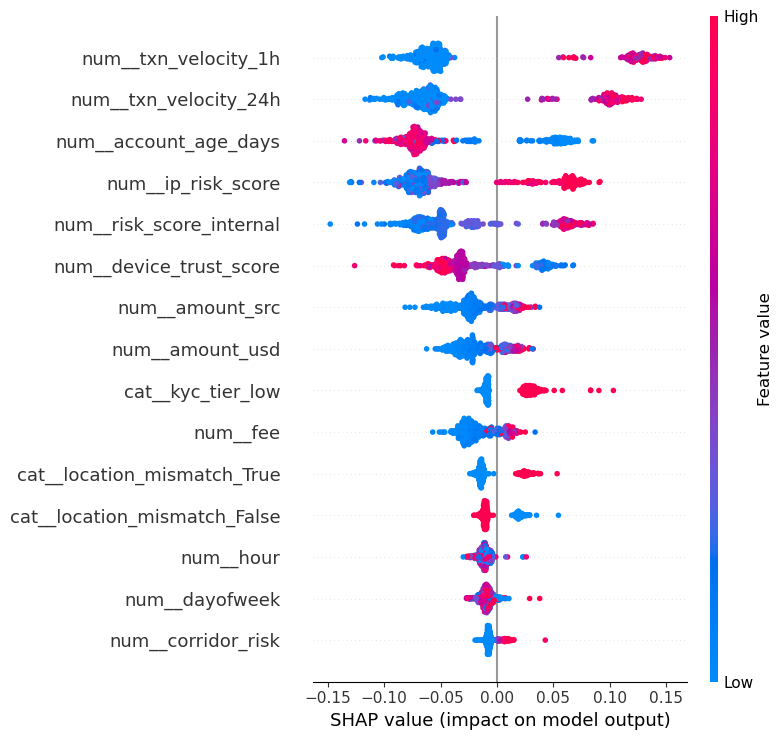

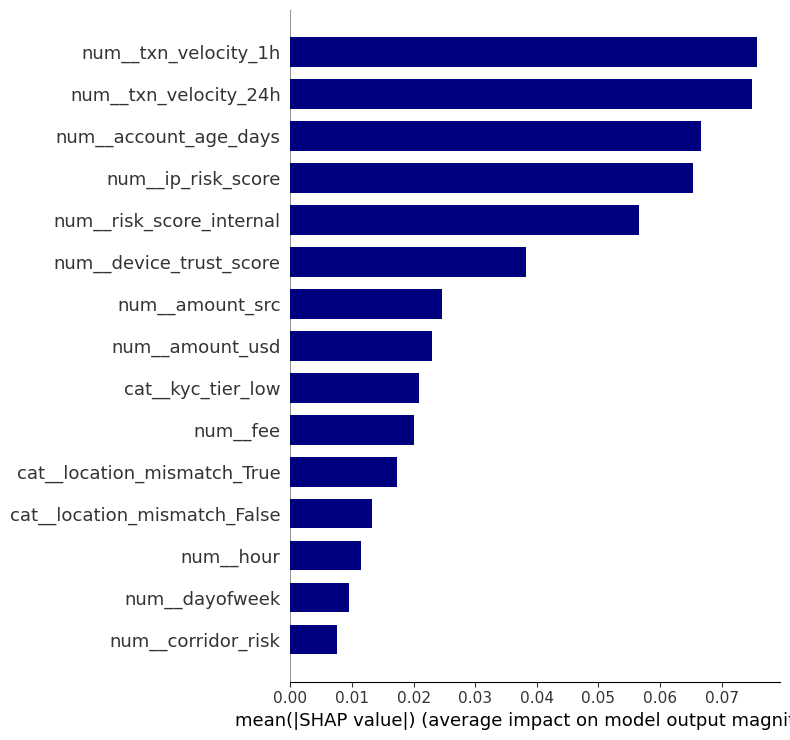

In [47]:
# Global Summary Plot

if isinstance(shap_values, list):
    sv_global = shap_value[1]
else:
    sv_arr = np.asarray(shap_values)
    if sv_arr.ndim == 3 and sv_arr.shape[-1] == 2:
        sv_global = sv_arr[:, :, 1]
    else:
        sv_global = sv_arr

shap.summary_plot(sv_global, X_enc_df, max_display=15, show=True)
shap.summary_plot(sv_global, X_enc_df, plot_type="bar", color="navy", max_display=15, show=True)


#### **Interpretation**

🔴 Red → high feature value
🔵 Blue → low feature value

#### Fraud risk is primarily driven by transaction velocity, account age, IP risk, and internal risk signals. High activity from new or risky accounts significantly increases fraud likelihood, while trusted devices and stable behavior reduce it – this implies that when a transaction comes from a known, trusted device, the model pushes the fraud probability down; when the device is new or untrusted, the model becomes more suspicious. Customers who transact slowly and regularly look normal, while sudden bursts or unusual activity look risky.
#### The model learns that customers using familiar devices and showing consistent transaction patterns are unlikely to be fraudulent. These signals counterbalance riskier factors and help prevent legitimate transactions from being wrongly blocked.